In [ ]:
import pandas as pd
import numpy as np
import glob
import datetime
import statistics
from matplotlib import pyplot as plt

n_cols = 25

def pad_list(arr, val, n):
    return arr +[val]*(n-len(arr))

pad_col_header = lambda arr: pad_list(arr, "", n_cols)

columns_shared = pad_col_header(["Record Type","District Code","Property id","Sale Counter", "Download Date/Time"])

column_headers = {
    "B": pad_col_header(["Record Type","District Code","Property id", "Sale Counter",
        "Download Date/Time","Property name","Property Unit Number","Property House Number",
        "Property Street Name","Property Locality","Property Post Code","Area",
        "Area Type","Contract Date","Settlement Date","Purchase Price","Zoning",
        "Nature of Property","Primary Purpose","Strata Lot Number","Component code",
        "Sale Code","% Interest of Sale","Dealing Number"]),
    "C": pad_col_header(["Record Type","District Code","Property id","Sale Counter",
        "Download Date/Time","Property Legal Description"]),
    "D": pad_col_header(["Record Type", "District Code","Property ID","Sale Counter","Download Date/Time",
        "Purchaser - Vendor"])
}

# dataRoot = "data/"
outputRoot = "outputs/"

calendar = ["January","February","March","April","May","June","July","August",
"September","October","November","December"]
property_types = 2
months_range = range(12)

def getDataframe(max_files=None, record_type="", dataRoot=""):
    print(dataRoot)
    filesNames = glob.glob(dataRoot+ "*.DAT")
    """The point of having another list of filenames which is shorter is so that we can test early drafts 
    of our code without too much run-time cost. If max_files is set equal to None then we just use the
    entire dataset.
    """
    if max_files is None:
        filesNamesShort = filesNames
    else:
        filesNamesShort = filesNames[:max_files]

    datasets = []
    for fileName in filesNamesShort:
        with open(fileName,"r") as f:
            lines = [l.strip().split(";") for l in f]
            datasets+=lines

    df = pd.DataFrame(datasets)
    df.columns = columns_shared
    df_restricted=df.loc[df["Record Type"]==record_type]
    df_restricted.columns=column_headers[record_type]
    return df_restricted



def write_output_file(output_file,max_prices):
    """The following is code common to read_the_data and task3.
    """
    for key, max_price_info in max_prices.items():
        for date, max_price in max_price_info.items():
            output_file.write(f"{key} {date} {max_price}\n")

class CachedDateStats:
    def __init__(self, df_b):
        self.df_b = df_b
        self._minimum_date = None
        self._maximum_date = None
        self._was_setup = False
    
    def setup(self):
        if not self._was_setup:
            dates = self.df_b["Settlement Date"].astype(int).tolist()
            self._minimum_date = datetime.datetime.strptime(str(min(dates)),'%Y%m%d').date()
            self._maximum_date = datetime.datetime.strptime(str(max(dates)),'%Y%m%d').date()
            self._was_setup = True
        return self

    def get_min_date(self):
        return self.setup()._minimum_date

    def get_max_date(self):
        return self.setup()._maximum_date

**You need to run this next section to connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Below is the importing and scraping of the property data**

### Webscraping and download

Below is the format of the years between 2001 and 2020 which is what is going to be pulled in first
https://www.valuergeneral.nsw.gov.au/__psi/yearly/2006.zip

https://valuation.property.nsw.gov.au/embed/propertySalesInformation


In [ ]:
# import requests

# # Range of all the available years - last 20
# years = range(2001,2021)

# # Function to download zip from a url
# def download_url(url, save_path, chunk_size=128):
#     r = requests.get(url, stream=True)
#     with open(save_path, 'wb') as fd:
#         for chunk in r.iter_content(chunk_size=chunk_size):
#             fd.write(chunk)

Now download the data with a loop and store in ./files

In [ ]:
# Iterate range of years and download
# for year in years:
#     valuer_url = f'https://www.valuergeneral.nsw.gov.au/__psi/yearly/{year}.zip'
#     output_path = f'/content/drive/Shareddrives/PropertyTrack/files/{year}.zip'
#     download_url(valuer_url, output_path)

Now we have to open the zips
These get stored in ./yearsData

In [ ]:
# from zipfile import ZipFile

# for year in years:
#     file_path = f'/content/drive/Shareddrives/PropertyTrack/files/{year}.zip'
#     output_path = f'/content/drive/Shareddrives/PropertyTrack/yearsData/{year}'
#     with ZipFile(file_path, 'r') as zipObj:
#         zipObj.extractall(output_path)

- 2001 to 2013 have folder of the same year name
    - Inside of the folder year name they have more folders, the name/dates are not the same for these folders.
    - Inside of here they have .DAT files - Naming conventions are different for each folder

In [ ]:
# This is for 2001 to 2013 - This is done and the files are in /rangeFour
# Create a dataframe and then add to the end
# import shutil
# import os as os

# # Create a range
# range_two = range(2001,2014)

# # # Search for the folders with these names
# for year in range_two:
#     # Get the name of the directory
#     dir_name = f'/content/drive/Shareddrives/PropertyTrack/yearsData/{year}/{year}'
    
#     # Create a list of the names of all the folders inside
#     folders_inside = os.listdir(dir_name)
    
#     # Iterate through the folder names
#     for folder in folders_inside:
#         # Check if it is the files we want
#         if '.txt' not in folder and '.DS_Store' not in folder:
#             # Inside of here is where we can navigate into the final folders
#             data_files_inside = os.listdir(f'/content/drive/Shareddrives/PropertyTrack/yearsData/{year}/{year}/{folder}')
#             # Now we have the names of the data files iterate through them
#             for datFile in data_files_inside:
#                 # Get the path of the source and destination
#                 source = f'/content/drive/Shareddrives/PropertyTrack/yearsData/{year}/{year}/{folder}/{datFile}'
#                 destination = f'/content/drive/Shareddrives/PropertyTrack/rangeOne/{datFile}.DAT'
                
#                 shutil.move(source, destination)

The data from this range is now in the folder rangeTwo
We can create a dataframe from this using the above functions

## Run the below cell to build a dataframe for files in range one (2001-2014)

In [ ]:
# In range one folder get the number of files
import shutil
import os as os
dir_name_two = '/content/drive/Shareddrives/PropertyTrack/rangeOne'
files = os.listdir(dir_name_two) # This is an array of names of folder... They have .zip on the end
file_count = len(files) # Get the number of files in the folder

# Create dataframe - This number can be changed
df_one = getDataframe(10000,"B",'/content/drive/Shareddrives/PropertyTrack/rangeOne/')

print(df_one.shape)
print("done")

/content/drive/Shareddrives/PropertyTrack/rangeOne/
(269139, 25)
done


We can now do some analysis on this dataframe

In [ ]:
# Defining a function to see how much ram we have
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
df_one.describe()

,Record Type,District Code,Property id,Sale Counter,Download Date/Time,Property name,Property Unit Number,Property House Number,Property Street Name,Property Locality,Property Post Code,Area,Area Type,Contract Date,Settlement Date,Purchase Price,Zoning,Nature of Property,Primary Purpose,Strata Lot Number,Component code,Sale Code,% Interest of Sale,Dealing Number,
count,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139,269139
unique,1,192,212142,825,3120,2954,1796,4045,39578,3799,618,26030,3,3440,2491,12350,51,3,1396,447,2711,108,83,260814,1
top,B,004,,1,20130401 01:05,,,,PACIFIC HWY,ORANGE,2250,,M,20111222,20010831,350000,A,R,RESIDENCE,,,,0,AH532768,
freq,269139,13210,451,10000,654,262829,191421,14604,1822,1898,5195,78079,172563,930,1347,2338,105801,207927,207049,188590,88056,257664,242643,87,269139


- 2014 to 2020 have zips in the folders
    - These have zips corresponding to each week of that year
    - The zips create folders
    - The folder have all of the data files for that week

In [ ]:
# Now we have to build a dataframe for years between 2014 and 2020

# range_three = range(2015,2021)

#This builds the folder full of zip files
# for year in range_three:
#     dir_name = f'./yearsData/{year}'
#     zips_inside = os.listdir(dir_name)
#     for zipfile in zips_inside:
#         # Move all of the zipped files into rangeThreeZipped
#         source = f'./yearsData/{year}/{zipfile}'
#         destination = f'./rangeThreeZipped/{zipfile}'  
#         shutil.move(source, destination)

In [ ]:
# Now all the zip files are in the zipped folder
# from zipfile import ZipFile

# dir_name = f'./rangeThreeZipped'

# zipped = os.listdir(dir_name)

# for file in zipped:
#     file_path = f'./rangeThreeZipped/{file}'
#     output_path = f'./rangeThreeUnzipped/{file}'
#     with ZipFile(file_path, 'r') as zipObj:
#         zipObj.extractall(output_path)

The tricky thing here is the 2015 data follows a seperate folder structure

In [ ]:
# Now we can go through and move all of the datafiles into ./rangeThree
# import os as os

# dir_name = f'./rangeThreeUnzipped'
# folder_names = os.listdir(dir_name) # This is an array of names of folder... They have .zip on the end

# for folder in folder_names:
#   if '.txt' not in folder and '.DS_Store' not in folder and '2015' not in folder: 
#     dir_name_folder = f'./rangeThreeUnzipped/{folder}'
#     secondFolder = os.listdir(dir_name_folder)
        
#     for folderTwo in secondFolder:
#       if '.txt' not in file and '.DS_Store' not in folderTwo and '2015' not in folder:
#         source = f'./rangeThreeUnzipped/{folder}/{file}'
#         destination = f'./rangeTwo/{file}'

#         shutil.move(source, destination)

Now for the 2015 data

In [ ]:
# Now we can go through and move all of the datafiles into ./rangeThree
# import os as os
# import shutil

# dir_name = f'./rangeThreeUnzipped'
# folder_names = os.listdir(dir_name) # This is an array of names of folder... They have .zip on the end

# for folder in folder_names:
#     if '.txt' not in folder and '.DS_Store' not in folder and '2015' in folder and '201510' not in folder and '201511' not in folder and '201512' not in folder: 

#         dir_name_folder = f'./rangeThreeUnzipped/{folder}'
#         secondFolder = os.listdir(dir_name_folder)
        
#         for folderTwo in secondFolder:
#             if '.txt' not in file and '.DS_Store' not in folderTwo and '2015' in folder and '201510' not in folder and '201511' not in folder and '201512' not in folder:
#                 dir_name_folder_two = f'./rangeThreeUnzipped/{folder}/{folderTwo}'
#                 datFiles = os.listdir(dir_name_folder_two)

#                 # print(datFiles)
  
#                 for datFile in datFiles:
#                   if '.txt' not in folder and '.DS_Store' not in folder and '2015' in folder and '201510' not in folder and '201511' not in folder and '201512' not in folder:
#                       source = f'./rangeThreeUnzipped/{folder}/{file}'
#                       destination = f'./rangeTwo/{file}'

#                       shutil.move(source, destination)

FileNotFoundError: ignored



---



# Cleaning the data

In [ ]:
#Testing with df_one | 100 records
df_one.head()

# Data points that aren't useful
# Dealing Number, Download DateTime, Property Name, Record Type, Strata Lot Number, Nature of Property

# Categorical inputs that have to change to numerical
# Property name, Property Stree Name, Property Locality, Property, Area Type (Hectares - Meters Sq) --> Needs to be made the same unit, Zoning, Nature of Property, Primary Purpose, Component Code, Sale Code
# Postcode/Locality is already categorised by district code

# Calculations
# Settlement period (Contract Date-Settlement Date in unix seconds time) - Doesn't affect purchase price - we can drop this one too
# District Medians
# Suburb Median
# Suburb Record
# Street Record


,Record Type,District Code,Property id,Sale Counter,Download Date/Time,Property name,Property Unit Number,Property House Number,Property Street Name,Property Locality,Property Post Code,Area,Area Type,Contract Date,Settlement Date,Purchase Price,Zoning,Nature of Property,Primary Purpose,Strata Lot Number,Component code,Sale Code,% Interest of Sale,Dealing Number,
1,B,043,477414,1,20131125 01:18,,,553,BALD HILLS RD,GRENFELL,2810,130,H,20131016,20131031,180000,RU1,V,VACANT LAND,,RME,,0,AI168877,
6,B,043,478663,2,20131125 01:18,,,671,LEWIS LANE,GRENFELL,2810,1.836,H,20131018,20131111,58300,RU1,3,SILO,,RMW,,0,AI170789,
12,B,013,328363,1,20131118 01:09,,,2991,THE LAKES WAY,TARBUCK BAY,2428,10.4,H,20131005,20131104,241000,R,V,VACANT LAND,,PN,,0,AI149251,
17,B,013,324672,2,20131118 01:09,,,94,BAYVIEW RD,TEA GARDENS,2324,839.7,M,20131009,20131104,655000,A,R,RESIDENCE,,AV,,0,AI151453,
22,B,013,325458,3,20131118 01:09,,,1,SETTLERS WAY,TEA GARDENS,2324,749,M,20130822,20131023,260000,A,V,VACANT LAND,,AV,,0,AI143587,


---
### Deleting some unneeded fields



In [ ]:
# Data points that aren't useful
# Dealing Number, Download DateTime, Property Name, Record Type, Strata Lot Number
df_one = df_one.drop('Dealing Number', 1)
df_one = df_one.drop('Record Type', 1)
df_one = df_one.drop('Download Date/Time', 1)
df_one = df_one.drop('Property name', 1)
df_one = df_one.drop('Strata Lot Number', 1)
df_one = df_one.drop('Settlement Date', 1)
df_one = df_one.drop('Nature of Property', 1)
df_one = df_one.drop('% Interest of Sale', 1)

In [ ]:
#Null Value check
df_one["Property id"].replace('',np.nan,inplace=True)
df_one['Property Post Code'].replace('',np.nan,inplace=True)
df_one['Purchase Price'].replace('',np.nan,inplace=True)

print(len(df_one[df_one['Property Post Code'] == '']))
print(len(df_one[df_one['Property id'] == '']))
print(len(df_one[df_one['Purchase Price'] == '']))

print(df_one["Property id"].isna().sum())
print(df_one["Property Post Code"].isna().sum())
print(df_one["Purchase Price"].isna().sum())

# Drop the null value
df_one = df_one[df_one['Property id'].notna()]
df_one = df_one[df_one['Property Post Code'].notna()]
df_one = df_one[df_one['Purchase Price'].notna()]

print(df_one["Property id"].isna().sum())
print(df_one["Property Post Code"].isna().sum())
print(df_one["Purchase Price"].isna().sum())



0
0
0
451
167
0
0
0
0


In [ ]:
df_one.head()

,District Code,Property id,Sale Counter,Property Unit Number,Property House Number,Property Street Name,Property Locality,Property Post Code,Area,Area Type,Contract Date,Purchase Price,Zoning,Primary Purpose,Component code,Sale Code,
1,043,477414,1,,553,BALD HILLS RD,GRENFELL,2810,130,H,20131016,180000,RU1,VACANT LAND,RME,,
6,043,478663,2,,671,LEWIS LANE,GRENFELL,2810,1.836,H,20131018,58300,RU1,SILO,RMW,,
12,013,328363,1,,2991,THE LAKES WAY,TARBUCK BAY,2428,10.4,H,20131005,241000,R,VACANT LAND,PN,,
17,013,324672,2,,94,BAYVIEW RD,TEA GARDENS,2324,839.7,M,20131009,655000,A,RESIDENCE,AV,,
22,013,325458,3,,1,SETTLERS WAY,TEA GARDENS,2324,749,M,20130822,260000,A,VACANT LAND,AV,,


In [ ]:
# Change numerical labels to numerical type
# pd.to_numeric(df_one["District Code"])
# pd.to_numeric(df_one["Property id"])
# pd.to_numeric(df_one["Sale Counter"])
# pd.to_numeric(df_one["Property Post Code"])
# pd.to_numeric(df_one["Area"])
# pd.to_numeric(df_one["Purchase Price"])

df_one["District Code"] = df_one["District Code"].astype(float)
df_one["Property id"] = df_one["Property id"].astype(int)
df_one["Sale Counter"] = df_one["Sale Counter"].astype(float)
df_one["Property Post Code"] = df_one["Property Post Code"].astype(int)
df_one["Purchase Price"] = df_one["Purchase Price"].astype(float)
# df_one["Area"].astype(float)

print(df_one.dtypes)

District Code            float64
Property id                int64
Sale Counter             float64
Property Unit Number      object
Property House Number     object
Property Street Name      object
Property Locality         object
Property Post Code         int64
Area                      object
Area Type                 object
Contract Date             object
Purchase Price           float64
Zoning                    object
Primary Purpose           object
Component code            object
Sale Code                 object
                          object
dtype: object


### Categorising some fields

**THIS BLOCK NEEDS TO RUN TO USE DF**



In [ ]:
df = df_one
df.head()

,District Code,Property id,Sale Counter,Property Unit Number,Property House Number,Property Street Name,Property Locality,Property Post Code,Area,Area Type,Contract Date,Purchase Price,Zoning,Primary Purpose,Component code,Sale Code,
1,43.0,477414,1.0,,553,BALD HILLS RD,GRENFELL,2810,130,H,20131016,180000.0,RU1,VACANT LAND,RME,,
6,43.0,478663,2.0,,671,LEWIS LANE,GRENFELL,2810,1.836,H,20131018,58300.0,RU1,SILO,RMW,,
12,13.0,328363,1.0,,2991,THE LAKES WAY,TARBUCK BAY,2428,10.4,H,20131005,241000.0,R,VACANT LAND,PN,,
17,13.0,324672,2.0,,94,BAYVIEW RD,TEA GARDENS,2324,839.7,M,20131009,655000.0,A,RESIDENCE,AV,,
22,13.0,325458,3.0,,1,SETTLERS WAY,TEA GARDENS,2324,749,M,20130822,260000.0,A,VACANT LAND,AV,,


In [ ]:
# See how many null values
# df.isna().sum() - There are no null values
df.shape

(268579, 17)

In [ ]:
# Categorical inputs that have to change to numerical
# Property name, Property Stree Name, Property Locality, Property, Area Type (Hectares - Meters Sq) --> Needs to be made the same unit, Zoning, Nature of Property, Primary Purpose, Component Code, Sale Code
# Postcode/Locality is already categorised by district code
# 100 files ~ 3246 rows
# See how many unique values there are in Street Name, Locality, Zoning, Primary Purpose, Component code
# df.nunique()

# Convert 
stringLabels = ["Property Street Name", "Property Locality","Zoning","Primary Purpose","Component code"]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def toNumericalLabels(arr):
    # Get all of the values as a list
    for label in arr:
        uniqueList = df[label].unique().tolist()

        # Fit and transform with label encoder
        encodedList = le.fit_transform(uniqueList)
        
        targets = df[label].unique()
        target2code = dict(zip(targets, range(len(targets))))
        df[f"{label}Numeric"] = df[label].apply(lambda x: target2code[x]) # convert each 
        
        print(df[f"{label}Numeric"].unique().tolist())


In [ ]:
toNumericalLabels(stringLabels)
df.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

,District Code,Property id,Sale Counter,Property Unit Number,Property House Number,Property Street Name,Property Locality,Property Post Code,Area,Area Type,Contract Date,Purchase Price,Zoning,Primary Purpose,Component code,Sale Code,,Property Street NameNumeric,Property LocalityNumeric,ZoningNumeric,Primary PurposeNumeric,Component codeNumeric
1,43.0,477414,1.0,,553,BALD HILLS RD,GRENFELL,2810,130,H,20131016,180000.0,RU1,VACANT LAND,RME,,,0,0,0,0,0
6,43.0,478663,2.0,,671,LEWIS LANE,GRENFELL,2810,1.836,H,20131018,58300.0,RU1,SILO,RMW,,,1,0,0,1,1
12,13.0,328363,1.0,,2991,THE LAKES WAY,TARBUCK BAY,2428,10.4,H,20131005,241000.0,R,VACANT LAND,PN,,,2,1,1,0,2
17,13.0,324672,2.0,,94,BAYVIEW RD,TEA GARDENS,2324,839.7,M,20131009,655000.0,A,RESIDENCE,AV,,,3,2,2,2,3
22,13.0,325458,3.0,,1,SETTLERS WAY,TEA GARDENS,2324,749,M,20130822,260000.0,A,VACANT LAND,AV,,,4,2,2,0,3


## Transform the datetime so that trasnformations can be done

In [ ]:
#  df["Date"] = pd.to_datetime(df['Contract Date'], format='%Y%m%d')
# df.set_index("Date")
#df = df.set_index("Date")
#df.head()
#  df = df.drop(['Contract Date'], axis=1)

Calculate montly median based on the month and postcode

In [ ]:
#month_group = df.groupby(by=[df.index.month, df.index.year, df["Property Post Code"]])

# View values - The dates are stored in tuples (M, YYYY)
#month_group.groups.keys()

# Now how do we use these dates
# We want to calculate the median purchase price of all the groups, the record price of the group, the low of the group, the number of sales per group



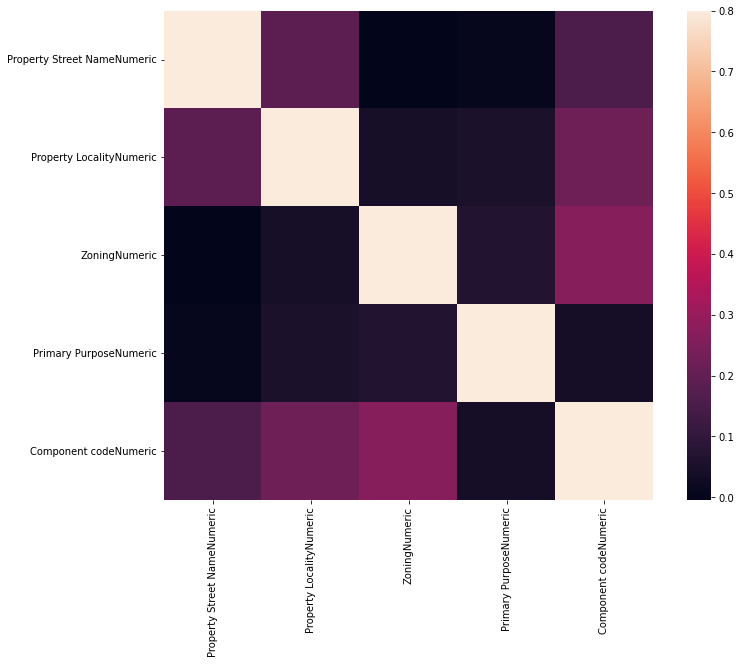

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# var = 'Property Locality'
# data = pd.concat([df['Purchase Price'], df[var]], axis=1)
# f, ax = plt.subplots(figsize=(16, 8))
# fig = sns.boxplot(x=var, y="Purchase Price", data=data)
# fig.axis(ymin=0, ymax=800000);
# plt.xticks(rotation=90);
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


### Now we want to standardise the area into Meters square

The conversion for hectares to meters squared is 10000 to 1
This means every row that has H has to multiplied by 10000

In [ ]:
# Convert empty string to nan values
df["Area Type"].replace('',np.nan,inplace=True)
df["Area"].replace('',np.nan,inplace=True)

print(len(df[df["Area Type"] == '']))
print(len(df[df["Area"] == '']))

print(df["Area Type"].isna().sum())
print(df["Area"].isna().sum())

# Get all the values that are not nan values
# # Drop the null value
df = df[df["Area Type"].notna()]
df = df[df["Area"].notna()]

print(df["Area Type"].isna().sum())
print(df["Area"].isna().sum())

0
0
77552
77549
0
0


In [ ]:
# Now in a new column if the area type if M move the value from 'Area' across otherwise if the value is 
# H then move multiple the value by 10000 and then move across
areaGroup = df.groupby(['Area Type'])

areaGroup.get_group("H")





,District Code,Property id,Sale Counter,Property Unit Number,Property House Number,Property Street Name,Property Locality,Property Post Code,Area,Area Type,Contract Date,Purchase Price,Zoning,Primary Purpose,Component code,Sale Code,,Property Street NameNumeric,Property LocalityNumeric,ZoningNumeric,Primary PurposeNumeric,Component codeNumeric
1,43.0,477414,1.0,,553,BALD HILLS RD,GRENFELL,2810,130,H,20131016,180000.0,RU1,VACANT LAND,RME,,,0,0,0,0,0
6,43.0,478663,2.0,,671,LEWIS LANE,GRENFELL,2810,1.836,H,20131018,58300.0,RU1,SILO,RMW,,,1,0,0,1,1
12,13.0,328363,1.0,,2991,THE LAKES WAY,TARBUCK BAY,2428,10.4,H,20131005,241000.0,R,VACANT LAND,PN,,,2,1,1,0,2
147,82.0,627342,10.0,,94 B,BAY RD,BERRILEE,2159,2.125,H,20130814,1500000.0,R,RESIDENCE,HC,,,28,11,1,2,13
275,82.0,632258,35.0,,63,CAIRNES RD,GLENORIE,2157,1.829,H,20130625,985000.0,R,RESIDENCE,HB,,,50,25,1,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391373,12.0,3586967,1.0,,,WADDELLS LANE,WHITTINGHAM,2330,10.7,H,20110419,90000.0,,VACANT LAND,,,,39539,556,3,0,4
1391378,12.0,3586970,2.0,,,BAKERS RD,PUTTY,2330,40.86,H,20110505,98000.0,,VACANT LAND,,,,6804,1466,3,0,4
1391402,12.0,302779,7.0,,94,NAWADAY WAY,WATTLE PONDS,2330,1.415,H,20110512,614000.0,R,RESIDENCE,RR,,,32589,1014,1,2,500
1391413,12.0,304727,9.0,,179,WAMBO RD,BULGA,2330,110,H,20110503,1225000.0,R,RESIDENCE,RK,,,26428,2094,1,2,792


## Split the training and test set

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ["District Code", "Sale Counter", "Property Post Code", "Property Street NameNumeric", "Property LocalityNumeric", "ZoningNumeric", "Primary PurposeNumeric", "Component codeNumeric"]
y = df["Purchase Price"]
X = df.loc[:, feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
print(X_test)
print(y_test)

         District Code  ...  Component codeNumeric
32083            224.0  ...                    227
1142027            3.0  ...                    191
1147675          656.0  ...                   2126
799457           162.0  ...                   1269
1348178            8.0  ...                    933
...                ...  ...                    ...
1267614            8.0  ...                    692
639474             8.0  ...                    431
1281591          218.0  ...                    116
1135664            1.0  ...                     37
977844            84.0  ...                    971

[57309 rows x 8 columns]
32083      441000.0
1142027    331000.0
1147675    725000.0
799457     261000.0
1348178    300000.0
             ...   
1267614    389950.0
639474     585000.0
1281591    285000.0
1135664    352000.0
977844     750000.0
Name: Purchase Price, Length: 57309, dtype: float64


# This is where the AI starts

### Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [ ]:
# Random Forest regressor

from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=500)

In [ ]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

**SVR**

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel="poly")

In [ ]:
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred_svr = svr.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

509552.82394162

In [ ]:
mean_squared_error(y_test, y_pred_svr,squared=False )

1884962.2473315205

In [ ]:
coefficient_of_dermination = r2_score(y_test, y_pred)
print(coefficient_of_dermination)

-0.024433821161765845


In [ ]:
df["Purchase Price"].mean()

821325.0397553517

In [ ]:
testymean = y_test.mean()
print(truemean)

820132.384279476


In [ ]:
j = 821325.0397553517 - 479624.97705009795
k = 821325.0397553517 + 479624.97705009795
print(j)
print(k)

341700.0627052538
1300950.0168054497


In [ ]:
SVRFRAE_numpy = np.sum(np.abs(np.subtract(y_test,y_pred_svr))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
print ("RAE using Numpy: % ", SVRFRAE_numpy)

RAE using Numpy: %  0.8827961456887374


In [ ]:
mean_squared_error(y_test, y_pred_svr, squared=False)

1884962.2473315205

# Results from the AI

In [ ]:
y_pred_RF = clf.predict(X_test)

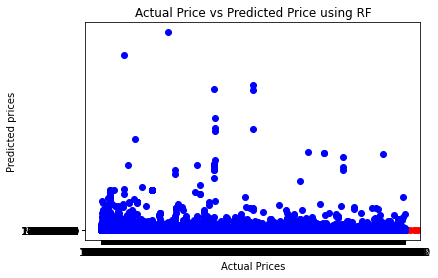

In [ ]:
plt.scatter(y_pred_RF, y_test, c='red')
plt.scatter(y_test, y_pred_RF, c='blue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual Price vs Predicted Price using RF")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_rf = mean_absolute_error(y_test, y_pred_RF)
print(mae_rf)


288736.12254273647


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
coefficient_of_dermination = r2_score(y_test, y_pred_RF)
print(coefficient_of_dermination)

0.5087274935857462


In [ ]:
RFRAE_numpy = np.sum(np.abs(np.subtract(y_test,y_pred_RF))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
print ("RAE using Numpy: % ", RFRAE_numpy)

RAE using Numpy: %  0.5103779737452115


In [ ]:
mean_squared_error(y_test, y_pred_RF, squared=False)

2201142.6627548826

In [ ]:
import math

In [ ]:
MSE = np.square(np.subtract(y_test,y_pred_RF)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1157717.5820278102


In [ ]:
df_pred = pd.DataFrame (y_pred, columns = ['prediction'])
print(df_pred)

       prediction
0    7.339400e+05
1    8.356980e+05
2    3.077450e+05
3    2.323289e+06
4    1.083040e+05
..            ...
682  6.636550e+05
683  4.820838e+05
684  1.798943e+05
685  1.158208e+06
686  3.621206e+05

[687 rows x 1 columns]


In [ ]:
futureSample_data =[]
futureSample_label = []
futureSample_data= X_test[2:100]
futureSample_label= y_test[2:100]
RFprediction = clf.predict(futureSample_data)

In [ ]:
print(RFprediction)

[ 307745.     2323289.2     108304.04    822888.578   159913.752
  979161.      318610.55    178076.23    703020.8     482764.
   39391.      844860.8     452438.      895958.2     568034.
  152700.4    2735830.     1183318.      700729.7     360009.
 1021239.     1313137.5     567755.072   381944.      660740.
  712992.854  1086945.686   332609.      423888.8    1238820.
  384586.8     481509.25    282545.124   148349.6    1655492.2
  789512.998  1626617.1     435599.      665464.196   742138.42
 1350886.8    1542652.      380648.      555433.8     520615.6
  622358.1784  471358.      418596.8   ]


In [ ]:
print(futureSample_label)

8201      265000.0
5795     1200000.0
13037      47000.0
13405      20000.0
820       200000.0
11747    1210000.0
9372      262500.0
6661      278000.0
5019     1100000.0
898       285000.0
1075        5500.0
14875     851500.0
7208      419500.0
2104     1888000.0
9996      515000.0
1945      102000.0
12912    2740000.0
2123      880000.0
16147     850000.0
13897     449000.0
15157     920000.0
15573     700000.0
15427     335000.0
1014      325000.0
7636      559950.0
8726      790000.0
7291      670000.0
1231      310000.0
7929      410000.0
15131     835000.0
8080      360000.0
3621      465000.0
9470      165000.0
3001      250000.0
629      1910000.0
4275     1050000.0
6518     1650000.0
14001     307000.0
4110     1425000.0
6939      820000.0
4410     2056000.0
4488     1770000.0
1306      550000.0
11824     590000.0
11445     428000.0
5698      925000.0
6326      535000.0
12978     408000.0
Name: Purchase Price, dtype: float64


In [ ]:
plt.scatter(futureSample_label, RFprediction, c='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price using RF")
plt.show()

NameError: ignored

In [ ]:
RFresidual = y_test - y_pred_RF

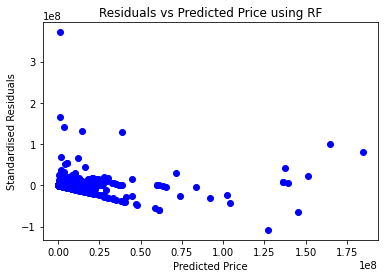

In [ ]:
plt.scatter(y_pred_RF, RFresidual, c='blue')
plt.xlabel("Predicted Price")
plt.ylabel("Standardised Residuals")
plt.title("Residuals vs Predicted Price using RF")
plt.show()

In [ ]:
truemean = df["Purchase Price"].mean()

821325.0397553517

In [ ]:
df.shape

(3246, 22)

In [ ]:
print(y_pred_RF)

In [ ]:
j = 821325.0397553517 - 293661.66593581275
k = 821325.0397553517 + 293661.66593581275
print(j)
print(k)

527663.373819539
1114986.7056911644


In [ ]:
def mean_absolute_percentage_error(y_test, y_pred_RF): 
    y_test, y_pred_RF = np.array(y_test), np.array(y_pred_RF)
mape = np.mean(np.abs((y_test - y_pred_RF) / y_test)) * 100
print(mape)

TypeError: ignored

## Decision Tree Regressor

In [ ]:
from sklearn import tree

clfDT = tree.DecisionTreeClassifier()

In [ ]:
clfDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
yDT_pred = clfDT.predict(X_test)

In [ ]:
DTRFRAE_numpy = np.sum(np.abs(np.subtract(y_test,yDT_pred))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
print ("RAE using Numpy: % ", DTRFRAE_numpy)

RAE using Numpy: %  0.5860321716115665


In [ ]:
mean_squared_error(y_test, yDT_pred,squared=False )

1355537.782524597

In [ ]:
DTprediction = clfDT.predict(futureSample_data)
print(DTprediction, futureSample_label)

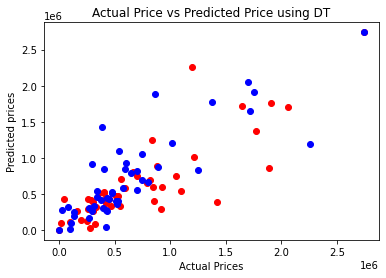

In [ ]:
plt.scatter(futureSample_label, DTprediction, c='red')
plt.scatter(DTprediction, futureSample_label, c='blue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual Price vs Predicted Price using DT")
plt.show()

In [ ]:
mean_absolute_error(y_test, yDT_pred)

338259.6870451237

In [ ]:
DTmean = (statistics.mean(yDT_pred))
print(DTmean)

888435.229985444


In [ ]:
def mean_absolute_percentage_error(y_test, yDT_pred): 
    y_test, yDT_pred = np.array(y_test), np.array(yDT_pred)
mape = np.mean(np.abs((y_test - yDT_pred) / y_test)) * 100
print(mape)

149.38030095486877


In [ ]:
coefficient_of_dermination = r2_score(y_test, yDT_pred)
print(coefficient_of_dermination)

0.47021232664103474


In [ ]:
j = 821325.0397553517 - 237477.5283842795
k = 821325.0397553517 + 237477.5283842795
print(j)
print(k)

583847.5113710723
1058802.5681396313


## ADA Boosted Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
clfAda = AdaBoostRegressor(n_estimators=4000)

In [ ]:
clfAda.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=4000, random_state=None)

In [ ]:
yADA_pred = clfAda.predict(X_test)

In [ ]:
ADARAE_numpy = np.sum(np.abs(np.subtract(y_test,yADA_pred))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
print ("RAE using Numpy: % ", ADARAE_numpy)

RAE using Numpy: %  1.072144454899552


In [ ]:
mean_squared_error(y_test, yADA_pred, squared=False)

1252833.060128025

In [ ]:
ADAprediction = clfAda.predict(futureSample_data)
print(ADAprediction, futureSample_label)

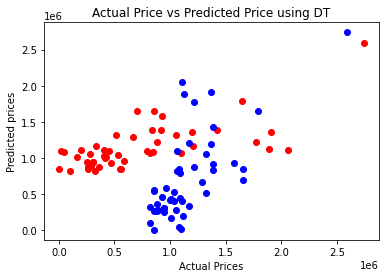

In [ ]:
plt.scatter(futureSample_label, ADAprediction, c='red')
plt.scatter(ADAprediction, futureSample_label, c='blue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual Price vs Predicted Price using DT")
plt.show()

In [ ]:
mean_absolute_error(y_test, yADA_pred)

618845.2875960323

In [ ]:
coefficient_of_dermination = r2_score(y_test, yADA_pred)
print(coefficient_of_dermination)

0.5474516294638874


## Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=500)

In [ ]:
mlp.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
y_pred_nn = mlp.predict(X_test)

In [ ]:
NNRAE_numpy = np.sum(np.abs(np.subtract(y_test,y_pred_nn))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
print ("RAE using Numpy: % ", NNRAE_numpy)

RAE using Numpy: %  1.0269710409024795


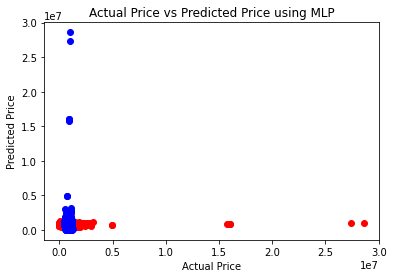

In [ ]:
plt.scatter(y_test, y_pred_nn, c='red')
plt.scatter(y_pred_nn, y_test, c='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price using MLP")
plt.show()

In [ ]:
MLPprediction = mlp.predict(futureSample_data)
print(MLPprediction, futureSample_label)

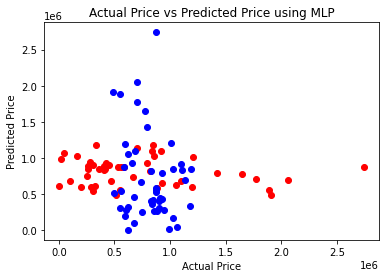

In [ ]:
plt.scatter(futureSample_label, MLPprediction, c='red')
plt.scatter(MLPprediction, futureSample_label, c='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price using MLP")
plt.show()

In [ ]:
mlp.score(X_test, y_test)

0.0005368897817812357

In [ ]:
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print(mae_nn)

592771.0452222916


In [ ]:
coefficient_of_dermination = r2_score(y_test, y_pred_nn)
print(coefficient_of_dermination)

0.0005368897817812357


In [ ]:
mean_squared_error(y_test, y_pred_nn,squared=False )

1861847.4185815079

In [ ]:
truemean = df["Purchase Price"].mean()

In [ ]:
def mean_absolute_percentage_error(truemean, mae_nn): 
    truemean, mae_nn = np.array(truemean), np.array(mae_nn)
mape = np.mean(np.abs((truemean - mae_nn) / truemean)) * 100
print(mape)

27.827471886299676


## Gradient Boosted Ensemble Method

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=500)

In [ ]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred_gb = gb.predict(X_test)

In [ ]:
GBRAE_numpy = np.sum(np.abs(np.subtract(y_test,y_pred_gb))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
print ("RAE using Numpy: % ", GBRAE_numpy)

RAE using Numpy: %  0.5311309324554438


In [ ]:
GBprediction = gb.predict(futureSample_data)
print(GBprediction, futureSample_label)

[ 312341.40420715  326665.93726445  463007.12748029  569538.78315783
 1324718.47170215  354194.41925713  874521.18531193  451749.83924365
  277549.85735813  449459.96271     662689.04103882  387352.82942021
  249088.02389214  641867.01493169  882256.36039308  505996.76231226
  419794.27889137  367900.5707679   513504.20374833  282731.90784321
  381756.99452359  751076.29061229 1151616.93211269  260175.25674659
  424535.44569952  370151.47474822  838753.50987365  747014.96996834
  501671.51857582  364810.50363031  327893.32440429  457872.8674641
  433072.96958101  417523.8938521   249156.45433343  453910.71512061
  376726.88678724  417565.66123424  390589.11992284  432417.98139442
  440076.15028309  277531.28082714  176089.20520204  655889.09453185
  303085.84978488  865873.85448233  436386.42141335 2037120.75640331
  268844.50800056  316071.35334385  463385.37205405 1026572.14559269
 1934815.2614159   521243.70918184  196662.61884208 1386936.36043453
 1403505.67608821 1860665.63443808 

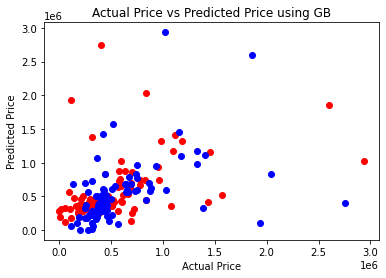

In [ ]:
plt.scatter(futureSample_label, GBprediction, c='red')
plt.scatter(GBprediction, futureSample_label, c='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price using GB")
plt.show()

In [ ]:
residual = y_test - y_pred_gb
print(residual)

32083       87703.427979
1142027   -165163.480043
1147675    412658.595793
799457     -65665.937264
1348178   -163007.127480
               ...      
1267614    -52710.016203
639474     127376.232583
1281591   -103219.122874
1135664    -38440.094640
977844    -470050.605232
Name: Purchase Price, Length: 57309, dtype: float64


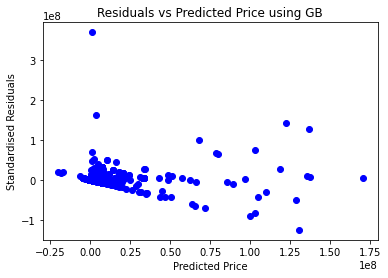

In [ ]:
plt.scatter(y_pred_gb, residual, c='blue')
plt.xlabel("Predicted Price")
plt.ylabel("Standardised Residuals")
plt.title("Residuals vs Predicted Price using GB")
plt.show()

In [ ]:
mae_gb = mean_absolute_error(y_test, y_pred_gb)
print(mae_gb)

362343.076105384


In [ ]:
coefficient_of_dermination = r2_score(y_test, y_pred_gb)
print(coefficient_of_dermination)

0.47629585328006796


In [ ]:
mean_squared_error(y_test, y_pred_gb,squared=False )

1237167.8726124328

In [ ]:
import numpy as np


In [ ]:
mean_squared_error(y_test, y_pred_gb)

1530584345024.3728

In [ ]:
sqrt(mean_squared_error(y_test, y_pred_gb)) 

1237167.8726124328

In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred_gb)
print(mape)


None


Text(0, 0.5, 'Residual')

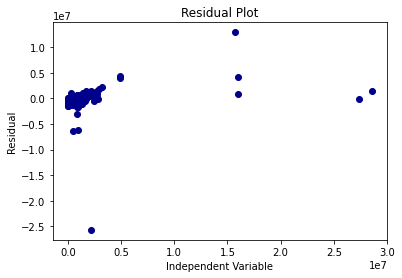

In [ ]:
residuals = y_test-y_pred_gb
plt.plot(y_test,residuals, 'o', color='darkblue')
plt.title("Residual Plot")
plt.xlabel("Independent Variable")
plt.ylabel("Residual")


In [ ]:
j = 821325.0397553517 - 362343.07
k = 821325.0397553517 + 362343.07
print(j)
print(k)

458981.9697553517
1183668.1097553517
